In [35]:
import json
import joblib
import pickle
import pandas as pd
import numpy as np
# import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import imblearn

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


### Import dataset

In [2]:
train = pd.read_csv('data/train.csv')

In [3]:
# no duplicate lines
train.duplicated().value_counts()

False    660611
dtype: int64

In [4]:
# no duplicate observation_id
train['observation_id'].duplicated().value_counts()

False    660611
Name: observation_id, dtype: int64

### Features adjustments

In [5]:
# transforming Date column in datetime
train['Date']=pd.to_datetime(train['Date'], infer_datetime_format=True)

# auxiliar Date feature (for temporal analyzis)
train['referencia'] = train['Date'].dt.year*100 + train['Date'].dt.month

# according to Dr Wilson's instructions: 
# "If there was a search and the outcome linked to object of search has not been written please consider it to be False"
train['Outcome linked to object of search'] = train['Outcome linked to object of search'].fillna(False)

# according to Dr Wilson's instructions missing values means False 
train['Part of a policing operation'] = train['Part of a policing operation'].fillna(False)

# Outer clothing be filled with False? 
#Yes, except when it’s just a vehicle search, in which case it makes no sense and should be kept as NaN
# mask= ((train['Type']!='Vehicle search') & 
#       (train['Removal of more than just outer clothing'] != True) &
#       (train['Removal of more than just outer clothing'] != False))

# train.loc[mask, 'Removal of more than just outer clothing']=False

train['Removal of more than just outer clothing'] = train['Removal of more than just outer clothing'].fillna(False)

### Filtering / Exclusions

In [6]:
# The Metropolitan station (which is very large and has lots of data in the training set) has the features 
# Outcome linked to object of search and Removal of outer clothing without any data (always missing). 
# Is this a known problem, and if so how should we proceed? 
# Thank you for bringing this to our attention, I’ve contacted the administration at the Metropolitan and asked that 
# they fix their data entry. Please include this in your report, and do not use the Metropolitan station’s data 
# for training your models. They will not be in the test set. 

In [7]:
# Gwent and Humberside have the same problem of Metropolitan. So I will exclude this observations
# dyfed-powys has 1.9% sucess rate, what is very low, so it will exclude for modeling proposes

In [8]:
stations_to_exclude = ['metropolitan', 'gwent', 'humberside', 'dyfed-powys']
train_model = train[~train['station'].isin(stations_to_exclude)]
print("Exclusion of {} observations".format(train[train['station'].isin(stations_to_exclude)]['observation_id'].nunique()))
train_model.shape

Exclusion of 360164 observations


(300447, 17)

In [9]:
# Search on individuals with less than 10 years seems unrealist, so I will remove it

In [10]:
# age_to_exclude = ['under 10']
# print("Exclusion of {} observations".format(train_model[train_model['Age range'].isin(age_to_exclude)]['observation_id'].nunique()))
# train_model = train_model[~train_model['Age range'].isin(age_to_exclude)]
# train_model.shape

### Target

In [11]:
positive_outcome = ['Local resolution',
           'Community resolution',
           'Arrest',
           'Article found - Detailed outcome unavailable',
           'Caution (simple or conditional)',
           'Khat or Cannabis warning',
           'Offender cautioned',
           'Offender given drugs possession warning',
           'Offender given penalty notice',
           'Penalty Notice for Disorder',
           'Summons / charged by post',
           'Suspect arrested',
           'Suspect summonsed to court',
           'Suspected psychoactive substances seized - No further action']

train_model['positive_outcome'] = train_model['Outcome'].isin(positive_outcome)

In [12]:
train_model['target'] = 0
mask=((train_model["positive_outcome"] == True) & (train_model["Outcome linked to object of search"]==True))
train_model.loc[mask, 'target']=1

In [13]:
pd.crosstab(train_model["positive_outcome"],train_model["Outcome linked to object of search"],
            margins=True, margins_name="Total",dropna=False)

Outcome linked to object of search,False,True,Total
positive_outcome,,,
False,172092,37859,209951
True,28291,62205,90496
Total,200383,100064,300447


In [14]:
print(train_model['target'].value_counts(dropna=False))
train_model['target'].value_counts(dropna=False,normalize=True)

0    238242
1     62205
Name: target, dtype: int64


0    0.792958
1    0.207042
Name: target, dtype: float64

In [15]:
# print(train_model['positive_outcome'].value_counts(dropna=False))
# train_model['positive_outcome'].value_counts(dropna=False,normalize=True)
# pd.crosstab(train_model["referencia"],train_model["target"],normalize='index')
# pd.crosstab(train_model["Gender"],train_model["target"],normalize='index')
# pd.crosstab(train_model["station"],train_model["target"],normalize='index')
# pd.crosstab(train_model["station"],train_model["positive_outcome"],normalize='index')

### Feature engineering

In [16]:
# get the hour and day of the week, maybe they will be useful 
train_model['hour'] = train_model['Date'].dt.hour
train_model['month'] = train_model['Date'].dt.month
train_model['day_of_week'] = train_model['Date'].dt.day_name()

In [17]:
# Legislation - reducing the quantity of categories
# train_model.groupby(['Legislation','target'], dropna=False)['Outcome'].count().unstack()

train_model['Legislation']=train_model['Legislation'].fillna('missing infomation')
train_model['Legislation'] = train_model['Legislation'].apply(lambda x: str(x).lower())

legislation_categories = ['misuse of drugs act 1971 (section 23)', 'police and criminal evidence act 1984 (section 1)', 
                          'criminal justice and public order act 1994 (section 60)', 'firearms act 1968 (section 47)'
                          ,'missing infomation'
                         ]

mask=(~train_model['Legislation'].isin(legislation_categories))
train_model.loc[mask, 'Legislation']='others'

train_model['Legislation'].value_counts()

misuse of drugs act 1971 (section 23)                      175438
police and criminal evidence act 1984 (section 1)           91781
missing infomation                                          27669
criminal justice and public order act 1994 (section 60)      2670
firearms act 1968 (section 47)                               1830
others                                                       1059
Name: Legislation, dtype: int64

### Text Data normalization

In [18]:
train_model['Object of search'] = train_model['Object of search'].apply(lambda x: str(x).lower())
# train_model['Object of search'].value_counts()

In [19]:
train_model['station'] = train_model['station'].apply(lambda x: str(x).lower())
# train_model['station'].value_counts()

In [20]:
train_model['Type'] = train_model['Type'].apply(lambda x: str(x).lower())

In [21]:
train_model['Age range'] = train_model['Age range'].apply(lambda x: str(x).lower())

In [22]:
train_model['Gender'] = train_model['Gender'].apply(lambda x: str(x).lower())

In [23]:
train_model['Officer-defined ethnicity'] = train_model['Officer-defined ethnicity'].apply(lambda x: str(x).lower())

In [24]:
train_model.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,...,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,referencia,positive_outcome,target,hour,month,day_of_week
0,34d76816-cfc2-4bdd-b3a2-bf0c40b12689,person search,2019-12-01 00:00:00+00:00,True,NaN,NaN,male,18-24,Asian/Asian British - Any other Asian background,asian,...,A no further action disposal,False,False,devon-and-cornwall,201912,False,0,0,12,Sunday
1,83c87ec1-e6d4-4bbb-8e0c-159516706359,person search,2019-12-01 00:09:00+00:00,True,NaN,NaN,male,18-24,NaN,white,...,A no further action disposal,False,False,devon-and-cornwall,201912,False,0,0,12,Sunday
2,8c2eae4b-035a-492f-92d6-cd27e6c900a1,person search,2019-12-01 00:10:00+00:00,True,NaN,NaN,female,18-24,White - English/Welsh/Scottish/Northern Irish/...,white,...,A no further action disposal,False,False,devon-and-cornwall,201912,False,0,0,12,Sunday
3,e63a036a-a728-4efe-8e08-7198f56d6d0a,person search,2019-12-01 00:10:00+00:00,False,NaN,NaN,male,18-24,NaN,asian,...,A no further action disposal,False,False,devon-and-cornwall,201912,False,0,0,12,Sunday
4,40c70aca-1f7f-4efe-8c5b-ade0f2e9937d,person search,2019-12-01 00:12:00+00:00,True,50.368247,-4.126646,male,18-24,NaN,white,...,A no further action disposal,False,False,devon-and-cornwall,201912,False,0,0,12,Sunday


### Latitude and Longitude

In [25]:
# print(train_model['Latitude'].describe())
# train_model['Longitude'].describe()

In [26]:
train_model['Latitude'] = train_model['Longitude'].fillna(0)
train_model['Longitude'] = train_model['Longitude'].fillna(50)

### Other variables adjustments

In [27]:
train['Age range'].value_counts(dropna=False)

18-24       241905
25-34       158181
10-17       131763
over 34     128378
under 10       384
Name: Age range, dtype: int64

In [28]:
train_model['Age range']=train_model['Age range'].replace({'under 10': 'under 18', '10-17': 'under 18'})

In [29]:
train_model['Age range'].value_counts(dropna=False)

18-24       102548
25-34        72861
over 34      65541
under 18     59497
Name: Age range, dtype: int64

In [30]:
train['Officer-defined ethnicity'].value_counts(dropna=False)

White    378311
Black    174593
Asian     86035
Other     19842
Mixed      1830
Name: Officer-defined ethnicity, dtype: int64

In [31]:
train_model['Officer-defined ethnicity'] = train_model['Officer-defined ethnicity'].replace({'mixed': 'other'})

In [32]:
train_model['Officer-defined ethnicity'].value_counts(dropna=False)

white    235885
black     32261
asian     24533
other      7768
Name: Officer-defined ethnicity, dtype: int64

### Over and Undersampling

In [ ]:
RandomUnderSampler(sampling_strategy='minority')

In [38]:
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='all')

In [43]:
# fit and apply the transform
X_under, y_under = undersample.fit_resample(train_model, train_model['Officer-defined ethnicity'])

In [44]:
X_under.shape

(31072, 22)

In [45]:
X_under['Officer-defined ethnicity'].value_counts()

black    7768
other    7768
asian    7768
white    7768
Name: Officer-defined ethnicity, dtype: int64

In [60]:
oversample = RandomOverSampler(sampling_strategy='not minority')

In [61]:
# fit and apply the transform
X_over, y_over = oversample.fit_resample(train_model, train_model['Officer-defined ethnicity'])

In [62]:
X_over['Officer-defined ethnicity'].value_counts()

asian    235885
black    235885
white    235885
other      7768
Name: Officer-defined ethnicity, dtype: int64

In [64]:
train_model['Officer-defined ethnicity'].value_counts()

white    235885
black     32261
asian     24533
other      7768
Name: Officer-defined ethnicity, dtype: int64

In [65]:
oversample2 = RandomOverSampler(sampling_strategy='minority')

In [72]:
X_other = X_over[X_over['Officer-defined ethnicity']=='other']
aux = X_other
X_other =X_other.append(aux)
X_other =X_other.append(aux)
X_other =X_other.append(aux)
X_other.shape

(31072, 22)

In [73]:
train_balance = X_over.append(X_other)

In [74]:
train_balance['Officer-defined ethnicity'].value_counts()

asian    235885
black    235885
white    235885
other     38840
Name: Officer-defined ethnicity, dtype: int64

In [75]:
train_balance['target'].value_counts(normalize=True)

0    0.79368
1    0.20632
Name: target, dtype: float64

### Data split

In [76]:
df_train, df_test = train_test_split(train_balance, test_size=0.3, random_state=42)

In [77]:
df_train.shape

(522546, 22)

In [78]:
df_test.shape

(223949, 22)

### Training a baseline model

In [79]:
all_features = ['Type', 'Part of a policing operation', 'Age range', 'Latitude', 'Longitude',
                'Legislation', 'hour', 'month', 'day_of_week']

numerical_features = ['hour', 'month','Latitude', 'Longitude']

categorical_features = ['Type', 'Part of a policing operation', 'Age range',
                        'Legislation', 'day_of_week']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = make_pipeline(
    preprocessor,
    RandomForestClassifier(max_depth=300, min_samples_leaf=.001, class_weight="balanced", random_state=42, n_jobs=-1),
)


X_train = df_train[all_features]
y_train = df_train['target']

pipeline.fit(X_train, y_train)

X_test = df_test[all_features]
y_test = df_test['target']

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)
y_pred_train = pipeline.predict(X_train)

roc_auc_score(y_test, y_pred)

0.6114459482457061

In [80]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba[:,1])

In [81]:
precision = precision[:-1]
recall = recall[:-1]

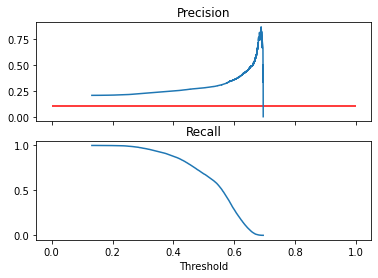

In [82]:
fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.hlines(y=0.1,xmin=0, xmax=1, colors='red')
ax1.plot(thresholds,precision)
ax2.plot(thresholds,recall)
ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
plt.xlabel('Threshold')
ax1.set_title('Precision')
ax2.set_title('Recall')
plt.show()

In [83]:
min_index = [i for i, prec in enumerate(precision) if prec > 0.25][0]
print(min_index)
thresholds[min_index]

27910


0.4065762960615967

In [84]:
precision[min_index]

0.25000310185242625

In [85]:
recall[min_index]

0.8717443973349485

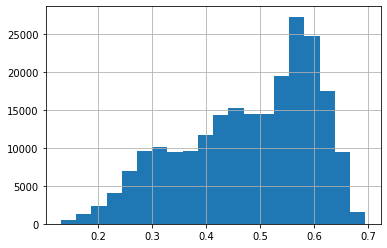

In [86]:
pd.Series(y_proba[:,1]).hist(bins=20, figsize=(6, 4));
# df.hist(column='SubjectAge', bins=20, figsize=(6, 4));

In [87]:
threshold = thresholds[min_index]
y_pred_threshold = pd.Series([True if p >= threshold else False for p in y_proba[:,1]]).to_numpy()

In [88]:
print(type(y_pred))
type(y_pred_threshold)

<class 'numpy.ndarray'>


numpy.ndarray

#### most important features

Feature ranking:
1. feature Legislation_misuse of drugs act 1971 (section 23) (0.258371)
2. feature Legislation_police and criminal evidence act 1984 (section 1) (0.149960)
3. feature Longitude (0.110215)
4. feature Age range_under 18 (0.086773)
5. feature Latitude (0.083253)
6. feature hour (0.055549)
7. feature Age range_18-24 (0.040934)
8. feature Legislation_missing infomation (0.037045)
9. feature month (0.031771)


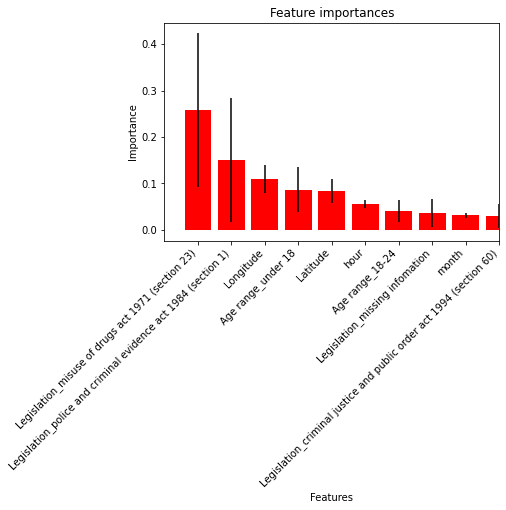

In [89]:
categorical_encode_step = pipeline.named_steps['columntransformer'].named_transformers_['cat'].named_steps['onehot']
random_forest_step = pipeline.named_steps['randomforestclassifier']

onehot_columns = categorical_encode_step.get_feature_names(input_features=categorical_features)

importances = pd.Series(data=random_forest_step.feature_importances_, index = np.array(numerical_features + list(onehot_columns)))

indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, importances.index[indices[f]], importances[indices[f]]))

std = np.std([tree.feature_importances_ for tree in random_forest_step.estimators_], axis=0)

plt.figure()
plt.title("Feature importances")
plt.bar(x=importances.index[indices], height=importances[indices],
        color="r", yerr=std[indices], align="center");
plt.xticks(range(len(importances.index[indices])), importances.index[indices], rotation=45, ha="right")
plt.xlim([-1, X_train.shape[1]])
plt.xlabel('Features');
plt.ylabel('Importance');

plt.show()

## Formalizing client requirements

### 1 - Minimum 10% success rate for searches per station and search objective

In [90]:
def verify_global_success_rate(y_true, y_pred, min_success_rate=0.1):
    """
    Verifies the success rate on a test set is above a provided minimum
    """
    
    precision = precision_score(y_true, y_pred, pos_label=1)
    is_satisfied = (precision >= min_success_rate)
    
    global_recall = recall_score(y_true, y_pred, pos_label=1)
    
    return is_satisfied, precision, global_recall

In [91]:
is_verified, success_rate, global_recall = verify_global_success_rate(y_test, y_pred_threshold)

print("Global Precision: {}".format((is_verified, success_rate)))
print("Global Recall: {}".format(global_recall))

Global Precision: (True, 0.25000310185242625)
Global Recall: 0.8717443973349485


In [92]:
def verify_success_rate_objective_station(X_test, y_true, y_pred, sensitive_column='Object of search', 
                                          min_success_rate=0.1, min_samples=50):
    """
    Verifies that success rate per station and search objective is higher than 10%
    """
    
#     exclusion_list = ['articles for use in criminal damage','anything to threaten or harm anyone','fireworks', 
#                  'detailed object of search unavailable','game or poaching equipment',
#                  'goods on which duty has not been paid etc.','evidence of wildlife offences',
#                  'crossbows','seals or hunting equipment']

    exclusion_list = ['articles for use in criminal damage','anything to threaten or harm anyone','fireworks',
                      'detailed object of search unavailable','game or poaching equipment',
                      'goods on which duty has not been paid etc.','evidence of wildlife offences',
                      'crossbows','seals or hunting equipment',
                      'firearms','evidence of offences under the act','psychoactive substances']
    
    departments = X_test['station'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    ignored_departments = []
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            if sensitive_class not in exclusion_list:
                mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department)
                if np.sum(mask) > min_samples:
                    precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
                
        if len(precisions) > 1:    
            precision_min = np.min(list(precisions.values()))

            if precision_min < min_success_rate:
                is_satisfied = False
                problematic_departments.append((department, precision_min, precisions))
            else:
                good_deparments.append((department, precision_min, precisions))
        else:
            ignored_departments.append((department, None, []))
    
    global_precisions = {}
    for department in departments:
        mask = (X_test['station'] == department)
        if np.sum(mask) > min_samples:
            global_precisions[department] = precision_score(y_true[mask], y_pred[mask])
            
    global_precisions_objective = {}
    for obj in sensitive_classes:
        mask = (X_test[sensitive_column] == obj)
        if np.sum(mask) > min_samples:
            global_precisions_objective[obj] = precision_score(y_true[mask], y_pred[mask])
    
        
    return is_satisfied, problematic_departments, good_deparments, ignored_departments, global_precisions,global_precisions_objective

In [93]:
is_satisfied, problematic_departments, good_deparments, ignored_departments,global_precisions, global_precisions_objective = verify_success_rate_objective_station(df_test, y_test, y_pred_threshold, min_success_rate=0.1)

if not is_satisfied:
    print("Requirement failed 😢")
    print("Num problematic stations: {}".format(len(problematic_departments)))
    print("Num good stations: {}".format(len(good_deparments)))
    print("Num ignored departments: {}".format(len(ignored_departments)))
    print("\nObject of search rates: {}".format(global_precisions_objective))
    print("\nStation rates: {}".format(global_precisions))


Requirement failed 😢
Num problematic stations: 12
Num good stations: 26
Num ignored departments: 0

Object of search rates: {'article for use in theft': 0.16465712132629992, 'controlled drugs': 0.26458685027238615, 'offensive weapons': 0.16659128599427106, 'stolen goods': 0.2645459040712049, 'articles for use in criminal damage': 0.011768082663605052, 'firearms': 0.15027322404371585, 'anything to threaten or harm anyone': 0.12327586206896551, 'evidence of offences under the act': 0.18335684062059238, 'psychoactive substances': 0.28277439024390244, 'fireworks': 0.0, 'detailed object of search unavailable': 0.3181818181818182}

Station rates: {'lincolnshire': 0.18778026905829595, 'essex': 0.2953271028037383, 'west-mercia': 0.326025459688826, 'leicestershire': 0.15841584158415842, 'warwickshire': 0.26082474226804125, 'hertfordshire': 0.28718783930510317, 'west-yorkshire': 0.21495268534185624, 'south-yorkshire': 0.1938409219724164, 'norfolk': 0.1668472372697725, 'merseyside': 0.24543764203

In [97]:
problematic_departments

[('leicestershire',
  0.0547945205479452,
  {'article for use in theft': 0.14666666666666667,
   'controlled drugs': 0.1622445867642574,
   'offensive weapons': 0.15714285714285714,
   'stolen goods': 0.0547945205479452}),
 ('south-yorkshire',
  0.0,
  {'article for use in theft': 0.0,
   'controlled drugs': 0.1938409219724164,
   'offensive weapons': 0.0,
   'stolen goods': 0.0}),
 ('norfolk',
  0.0,
  {'article for use in theft': 0.0,
   'controlled drugs': 0.16954022988505746,
   'offensive weapons': 0.18181818181818182,
   'stolen goods': 0.16666666666666666}),
 ('lancashire',
  0.06666666666666667,
  {'article for use in theft': 0.06666666666666667,
   'controlled drugs': 0.2581967213114754,
   'offensive weapons': 0.17647058823529413,
   'stolen goods': 0.1794871794871795}),
 ('thames-valley',
  0.035555555555555556,
  {'article for use in theft': 0.035555555555555556,
   'controlled drugs': 0.1917994823593516,
   'offensive weapons': 0.10105580693815988,
   'stolen goods': 0.134

In [52]:
# good_deparments

In [94]:
print(min(global_precisions.values()))
max(global_precisions.values())

0.08338518979464841


0.38095238095238093

In [95]:
global_precisions.values()

dict_values([0.18778026905829595, 0.2953271028037383, 0.326025459688826, 0.15841584158415842, 0.26082474226804125, 0.28718783930510317, 0.21495268534185624, 0.1938409219724164, 0.1668472372697725, 0.24543764203567248, 0.08338518979464841, 0.2565418163160595, 0.1756191337781296, 0.2688434048083171, 0.26582278481012656, 0.15664439495174462, 0.30156682027649767, 0.38095238095238093, 0.29087875417130143, 0.26029609690444144, 0.3099183774424932, 0.270859021783806, 0.2583616093068347, 0.2887517146776406, 0.2337976983646275, 0.25609422076143523, 0.2827652424387902, 0.26595269968763946, 0.21236559139784947, 0.3502897617514488, 0.23471400394477318, 0.28860666298545923, 0.26166134185303513, 0.2853185595567867, 0.2356746765249538, 0.28350515463917525, 0.2993103448275862, 0.1320754716981132])

In [96]:
print(min(global_precisions_objective.values()))
max(global_precisions_objective.values())

0.0


0.3181818181818182

### 2 - No police station should have a discrepancy bigger than 5% between the search success rate between protected classes (ethnicity, gender)

In [98]:
def verify_no_discrimination(X_test, y_true, y_pred, sensitive_column, max_diff=0.05, min_samples=50):
    """
    Verifies that no station has discrimination in between protected classes
    """
    exclusion_class = ['Other']
    
    departments = X_test['station'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    ignored_departments = []
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            if sensitive_class not in exclusion_class:
                mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department)
                if np.sum(mask) > min_samples:
                    precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
                
        if len(precisions) > 1:    
            diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))

            if diff > max_diff:
                is_satisfied = False
                problematic_departments.append((department, diff, precisions))
            else:
                good_deparments.append((department, diff, precisions))
        else:
            ignored_departments.append((department, None, []))
    
    global_precisions = {}
    for sensitive_class in sensitive_classes:
        mask = (X_test[sensitive_column] == sensitive_class)
        if np.sum(mask) > min_samples:
            global_precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
    
    if len(precisions) > 1:    
        diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
        if diff > max_diff:
            is_satisfied = False
        
    return is_satisfied, problematic_departments, good_deparments, ignored_departments, global_precisions


In [109]:
is_satisfied_e, problematic_departments_e, good_deparments_e, ignored_departments_e, global_precisions_e = verify_no_discrimination(
    df_test, y_test, y_pred_threshold, 'Officer-defined ethnicity', 0.05)

print("\nEthnicity")

if not is_satisfied_e:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_precisions_e))
    print("Num problematic departments: {}".format(len(problematic_departments_e)))
    print("Num good departments: {}".format(len(good_deparments_e)))
    print("Num ignored departments: {}".format(len(ignored_departments_e)))

    print("avg diff:", np.mean([p[1] for p in problematic_departments_e]))
    
    
is_satisfied, problematic_departments, good_deparments, ignored_departments, global_precisions = verify_no_discrimination(
    df_test, y_test, y_pred_threshold, 'Gender', 0.05)

print("\n\nGender")

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("Num ignored departments: {}".format(len(ignored_departments)))
    
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))


Ethnicity
Requirement failed 😢
Global rates: {'black': 0.2595719694668853, 'asian': 0.24250686358042223, 'white': 0.24768518518518517, 'other': 0.2547951693109164}
Num problematic departments: 33
Num good departments: 5
Num ignored departments: 0
avg diff: 0.10276955722536729


Gender
Requirement failed 😢
Global rates: {'male': 0.25148974985518635, 'female': 0.22915898192548875, 'other': 0.267515923566879}
Num problematic departments: 17
Num good departments: 21
Num ignored departments: 0
avg diff: 0.08281574693048367


In [103]:
problematic_departments_e

[('west-mercia',
  0.10188642913737533,
  {'black': 0.3907427341227126,
   'asian': 0.3103448275862069,
   'white': 0.28885630498533726,
   'other': 0.38175675675675674}),
 ('leicestershire',
  0.132521116650442,
  {'black': 0.13473877176901924,
   'asian': 0.18756698821007503,
   'white': 0.13263785394932937,
   'other': 0.05504587155963303}),
 ('warwickshire',
  0.11193053197509906,
  {'black': 0.31085526315789475,
   'asian': 0.2289348171701113,
   'white': 0.26305609284332687,
   'other': 0.1989247311827957}),
 ('south-yorkshire',
  0.10018796992481205,
  {'black': 0.21613832853025935,
   'asian': 0.17481203007518797,
   'white': 0.191713048855906,
   'other': 0.275}),
 ('norfolk',
  0.10968650933427264,
  {'black': 0.10588235294117647,
   'asian': 0.18518518518518517,
   'white': 0.19414316702819956,
   'other': 0.2155688622754491}),
 ('durham',
  0.1731800766283525,
  {'asian': 0.5287356321839081, 'white': 0.35555555555555557}),
 ('bedfordshire',
  0.1828105928658612,
  {'black':

### 3 - No police station should have a discrepancy bigger than x% between the Removal of more than just outer clothing rate between protected classes (age, ethnicity, gender)

In [105]:
def verify_removal_clothing(X_test, y_true, y_pred, sensitive_column, max_diff, min_samples=50):
    """
    Verifies that no station has discrepancy Removal of more than just outer clothing rate between 
    protected classes (age, ethnicity, gender)
    """
    exclusion_class = ['Other']
    exclusion_stations_removalclothes = ['cleveland', 'north-yorkshire', 'surrey']
    
    departments = X_test['station'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    ignored_departments = []
    for department in departments:
        if department not in exclusion_stations_removalclothes:
            removal_rate = {}
            for sensitive_class in sensitive_classes:
                if sensitive_class not in exclusion_class:
                    mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department) & (y_pred == 1)
                    if np.sum(mask) > min_samples:
                        removal_rate[sensitive_class] = (np.sum(X_test[mask]['Removal of more than just outer clothing']==1))/(X_test[mask]['Removal of more than just outer clothing'].shape[0])
                
        if len(removal_rate) > 1:    
            diff = np.max(list(removal_rate.values())) - np.min(list(removal_rate.values()))

            if diff > max_diff:
                is_satisfied = False
                problematic_departments.append((department, diff, removal_rate))
            else:
                good_deparments.append((department, diff, removal_rate))
        else:
            ignored_departments.append((department, None, []))
    
    global_removal_rate = {}
    for sensitive_class in sensitive_classes:
        mask = (X_test[sensitive_column] == sensitive_class) & (y_pred == True)
        if np.sum(mask) > min_samples:
            global_removal_rate[sensitive_class] = (np.sum(X_test[mask]['Removal of more than just outer clothing']==True))/(X_test[mask]['Removal of more than just outer clothing'].shape[0])

        
    return is_satisfied, problematic_departments, good_deparments, ignored_departments, global_removal_rate


In [106]:
is_satisfied, problematic_departments, good_deparments, ignored_departments, global_removal_rate = verify_removal_clothing(
    df_test, y_test, y_pred_threshold, 'Gender', 0.05)

print("\nGender")

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_removal_rate))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("Num ignored departments: {}".format(len(ignored_departments)))
    
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
    
    
is_satisfied, problematic_departments, good_deparments, ignored_departments, global_removal_rate = verify_removal_clothing(
    df_test, y_test, y_pred_threshold, 'Age range', 0.05)

print("\n\nAge range")

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_removal_rate))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("Num ignored departments: {}".format(len(ignored_departments)))
    
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
    
    
is_satisfied, problematic_departments, good_deparments, ignored_departments, global_removal_rate = verify_removal_clothing(
    df_test, y_test, y_pred_threshold, 'Officer-defined ethnicity', 0.1)

print("\n\nEthnicity")

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_removal_rate))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("Num ignored departments: {}".format(len(ignored_departments)))
    
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))


Gender
Requirement failed 😢
Global rates: {'male': 0.06076847789177924, 'female': 0.05431575064551826, 'other': 0.03184713375796178}
Num problematic departments: 7
Num good departments: 30
Num ignored departments: 1
avg diff: 0.0968632076882201


Age range
Requirement failed 😢
Global rates: {'25-34': 0.059035779966012523, 'under 18': 0.051816327655586795, '18-24': 0.06614215797860232, 'over 34': 0.0535426731078905}
Num problematic departments: 19
Num good departments: 19
Num ignored departments: 0
avg diff: 0.09085996874449609


Ethnicity
Requirement failed 😢
Global rates: {'black': 0.09512239567515034, 'asian': 0.05227681529868409, 'white': 0.036146723646723646, 'other': 0.05150367037650959}
Num problematic departments: 14
Num good departments: 24
Num ignored departments: 0
avg diff: 0.16331662947932063


### SERIALIZE

In [63]:
# with open('columns.json', 'w') as fh:
#     json.dump(X_train.columns.tolist(), fh)
    
# with open('dtypes.pickle', 'wb') as fh:
#     pickle.dump(X_train.dtypes, fh)
    
# joblib.dump(pipeline, 'pipeline.pickle');

In [61]:
X_train.columns.tolist()

['Type',
 'Part of a policing operation',
 'Age range',
 'Latitude',
 'Longitude',
 'Legislation',
 'hour',
 'month',
 'day_of_week']

In [62]:
X_train.dtypes

Type                             object
Part of a policing operation       bool
Age range                        object
Latitude                        float64
Longitude                       float64
Legislation                      object
hour                              int64
month                             int64
day_of_week                      object
dtype: object